In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)


class AffectNetDatasetForSupCon(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 transform,
                 return_labels=True,
                 crop=False,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.crop = crop
        self.transform = transform
        self.return_labels = return_labels
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        img1 = self.transform(img)
        img2 = self.transform(img)
        if self.return_labels:
            target = torch.tensor(self.df['valence'][idx])
            if target < -0.5:
                target = torch.tensor(0)
            elif target > 0.5:
                target = torch.tensor(2)
            else:
                target = torch.tensor(1)
            return (img1.float(), img2.float()), target
        else:
            return img1.float(), img2.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def contrastive_collate_fn(examples):
    imgs, targets = zip(*examples)
    imgs1, imgs2 = zip(*imgs)
    imgs1 = torch.stack(imgs1)
    imgs2 = torch.stack(imgs2)
    pixel_values = torch.cat([imgs1, imgs2])
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/training.csv',
                                                images_root,
                                                crop=False,
                                                transform=supcon_transform,
                                                invalid_files=train_invalid_files)

print('contrastive:', len(contrastive_dataset))

contrastive: 320739


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(contrastive_dataset, collate_fn=contrastive_collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([4])


In [10]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SupConTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        bsz = labels.shape[0]
        outputs = model(pixel_values=inputs.get('pixel_values'), output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features, labels)
        return (loss, features) if return_outputs else loss

In [11]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=128,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', group='affectnet-contrastive', name='valencelabel-SupCon-pretrain')

contrastive_args = TrainingArguments(
    f"affectnet-valence-supcon",
    save_strategy='epoch',
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=1000,
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
trainer = SupConTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=contrastive_collate_fn,
    tokenizer=feature_extractor,
)

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  2%|▏         | 1000/60141 [12:07<11:46:25,  1.40it/s]

{'loss': 4.0438, 'learning_rate': 9.833724081741242e-07, 'epoch': 0.05}


  3%|▎         | 2000/60141 [24:04<11:15:19,  1.43it/s]

{'loss': 3.3313, 'learning_rate': 9.667448163482482e-07, 'epoch': 0.1}


  5%|▍         | 3000/60141 [35:58<10:58:35,  1.45it/s]

{'loss': 3.3098, 'learning_rate': 9.501172245223724e-07, 'epoch': 0.15}


  7%|▋         | 4000/60141 [47:55<11:10:55,  1.39it/s]

{'loss': 3.2986, 'learning_rate': 9.334896326964965e-07, 'epoch': 0.2}


  8%|▊         | 5000/60141 [59:52<10:42:36,  1.43it/s]

{'loss': 3.2947, 'learning_rate': 9.168620408706207e-07, 'epoch': 0.25}


 10%|▉         | 6000/60141 [1:11:49<11:04:21,  1.36it/s]

{'loss': 3.286, 'learning_rate': 9.002344490447447e-07, 'epoch': 0.3}


 12%|█▏        | 7000/60141 [1:23:47<10:39:41,  1.38it/s]

{'loss': 3.2846, 'learning_rate': 8.83606857218869e-07, 'epoch': 0.35}


 13%|█▎        | 8000/60141 [1:35:42<10:13:13,  1.42it/s]

{'loss': 3.2895, 'learning_rate': 8.669792653929931e-07, 'epoch': 0.4}


 15%|█▍        | 9000/60141 [1:47:39<9:53:56,  1.44it/s] 

{'loss': 3.2785, 'learning_rate': 8.503516735671172e-07, 'epoch': 0.45}


 17%|█▋        | 10000/60141 [1:59:35<9:54:25,  1.41it/s]

{'loss': 3.2821, 'learning_rate': 8.337240817412415e-07, 'epoch': 0.5}


 18%|█▊        | 11000/60141 [2:11:31<9:39:59,  1.41it/s] 

{'loss': 3.278, 'learning_rate': 8.170964899153655e-07, 'epoch': 0.55}


 20%|█▉        | 12000/60141 [2:23:28<9:18:26,  1.44it/s] 

{'loss': 3.2682, 'learning_rate': 8.004688980894897e-07, 'epoch': 0.6}


 22%|██▏       | 13000/60141 [2:35:28<9:16:01,  1.41it/s] 

{'loss': 3.2705, 'learning_rate': 7.838413062636137e-07, 'epoch': 0.65}


 23%|██▎       | 14000/60141 [2:47:24<9:10:33,  1.40it/s] 

{'loss': 3.2749, 'learning_rate': 7.67213714437738e-07, 'epoch': 0.7}


 25%|██▍       | 15000/60141 [2:59:23<8:49:37,  1.42it/s]

{'loss': 3.2733, 'learning_rate': 7.505861226118621e-07, 'epoch': 0.75}


 27%|██▋       | 16000/60141 [3:11:24<8:45:07,  1.40it/s] 

{'loss': 3.264, 'learning_rate': 7.339585307859862e-07, 'epoch': 0.8}


 28%|██▊       | 17000/60141 [3:23:21<8:18:52,  1.44it/s]

{'loss': 3.2704, 'learning_rate': 7.173309389601104e-07, 'epoch': 0.85}


 30%|██▉       | 18000/60141 [3:35:19<8:15:28,  1.42it/s]

{'loss': 3.2602, 'learning_rate': 7.007033471342345e-07, 'epoch': 0.9}


 32%|███▏      | 19000/60141 [3:47:16<8:21:39,  1.37it/s]

{'loss': 3.2617, 'learning_rate': 6.840757553083587e-07, 'epoch': 0.95}


 33%|███▎      | 20000/60141 [3:59:13<8:09:23,  1.37it/s]

{'loss': 3.2639, 'learning_rate': 6.674481634824827e-07, 'epoch': 1.0}


 35%|███▍      | 21000/60141 [4:11:10<7:36:12,  1.43it/s] 

{'loss': 3.2588, 'learning_rate': 6.50820571656607e-07, 'epoch': 1.05}


 37%|███▋      | 22000/60141 [4:23:03<7:33:22,  1.40it/s]

{'loss': 3.265, 'learning_rate': 6.341929798307311e-07, 'epoch': 1.1}


 38%|███▊      | 23000/60141 [4:34:55<7:22:11,  1.40it/s]

{'loss': 3.2662, 'learning_rate': 6.175653880048552e-07, 'epoch': 1.15}


 40%|███▉      | 24000/60141 [4:46:48<7:16:29,  1.38it/s]

{'loss': 3.2607, 'learning_rate': 6.009377961789794e-07, 'epoch': 1.2}


 42%|████▏     | 25000/60141 [4:58:41<6:57:58,  1.40it/s]

{'loss': 3.258, 'learning_rate': 5.843102043531035e-07, 'epoch': 1.25}


 43%|████▎     | 26000/60141 [5:10:34<7:07:26,  1.33it/s]

{'loss': 3.2573, 'learning_rate': 5.676826125272277e-07, 'epoch': 1.3}


 45%|████▍     | 27000/60141 [5:22:29<6:25:39,  1.43it/s]

{'loss': 3.2564, 'learning_rate': 5.510550207013518e-07, 'epoch': 1.35}


 47%|████▋     | 28000/60141 [5:34:24<6:14:49,  1.43it/s]

{'loss': 3.2505, 'learning_rate': 5.34427428875476e-07, 'epoch': 1.4}


 48%|████▊     | 29000/60141 [5:46:17<6:12:59,  1.39it/s]

{'loss': 3.2598, 'learning_rate': 5.177998370496001e-07, 'epoch': 1.45}


 50%|████▉     | 30000/60141 [5:58:12<6:01:54,  1.39it/s]

{'loss': 3.2555, 'learning_rate': 5.011722452237242e-07, 'epoch': 1.5}


 52%|█████▏    | 31000/60141 [6:10:08<5:47:42,  1.40it/s]

{'loss': 3.2567, 'learning_rate': 4.845446533978484e-07, 'epoch': 1.55}


 53%|█████▎    | 32000/60141 [6:22:03<5:31:45,  1.41it/s]

{'loss': 3.2482, 'learning_rate': 4.679170615719725e-07, 'epoch': 1.6}


 55%|█████▍    | 33000/60141 [6:33:59<5:14:33,  1.44it/s]

{'loss': 3.2574, 'learning_rate': 4.512894697460967e-07, 'epoch': 1.65}


 57%|█████▋    | 34000/60141 [6:45:56<5:10:01,  1.41it/s]

{'loss': 3.25, 'learning_rate': 4.346618779202208e-07, 'epoch': 1.7}


 58%|█████▊    | 35000/60141 [6:57:53<4:50:38,  1.44it/s]

{'loss': 3.2553, 'learning_rate': 4.1803428609434494e-07, 'epoch': 1.75}


 60%|█████▉    | 36000/60141 [7:09:54<4:49:22,  1.39it/s]

{'loss': 3.2599, 'learning_rate': 4.0140669426846907e-07, 'epoch': 1.8}


 62%|██████▏   | 37000/60141 [7:21:55<4:34:07,  1.41it/s]

{'loss': 3.2536, 'learning_rate': 3.847791024425932e-07, 'epoch': 1.85}


 63%|██████▎   | 38000/60141 [7:33:56<4:32:33,  1.35it/s]

{'loss': 3.2502, 'learning_rate': 3.681515106167173e-07, 'epoch': 1.9}


 65%|██████▍   | 39000/60141 [7:45:57<4:03:52,  1.44it/s]

{'loss': 3.253, 'learning_rate': 3.515239187908415e-07, 'epoch': 1.95}


 67%|██████▋   | 40000/60141 [7:57:57<3:54:36,  1.43it/s]

{'loss': 3.249, 'learning_rate': 3.348963269649657e-07, 'epoch': 2.0}


 68%|██████▊   | 41000/60141 [8:09:54<3:43:29,  1.43it/s]

{'loss': 3.2518, 'learning_rate': 3.182687351390898e-07, 'epoch': 2.05}


 70%|██████▉   | 42000/60141 [8:21:49<3:34:27,  1.41it/s]

{'loss': 3.2491, 'learning_rate': 3.0164114331321395e-07, 'epoch': 2.1}


 71%|███████▏  | 43000/60141 [8:33:45<3:31:19,  1.35it/s]

{'loss': 3.2541, 'learning_rate': 2.850135514873381e-07, 'epoch': 2.14}


 73%|███████▎  | 44000/60141 [8:45:41<3:16:09,  1.37it/s]

{'loss': 3.2526, 'learning_rate': 2.683859596614622e-07, 'epoch': 2.19}


 75%|███████▍  | 45000/60141 [8:57:35<3:04:54,  1.36it/s]

{'loss': 3.2541, 'learning_rate': 2.5175836783558633e-07, 'epoch': 2.24}


 76%|███████▋  | 46000/60141 [9:09:29<2:46:06,  1.42it/s]

{'loss': 3.2563, 'learning_rate': 2.3513077600971052e-07, 'epoch': 2.29}


 78%|███████▊  | 47000/60141 [9:21:25<2:41:45,  1.35it/s]

{'loss': 3.2567, 'learning_rate': 2.1850318418383464e-07, 'epoch': 2.34}


 80%|███████▉  | 48000/60141 [9:33:19<2:18:16,  1.46it/s]

{'loss': 3.2548, 'learning_rate': 2.0187559235795877e-07, 'epoch': 2.39}


 81%|████████▏ | 49000/60141 [9:45:15<2:22:25,  1.30it/s]

{'loss': 3.2526, 'learning_rate': 1.8524800053208293e-07, 'epoch': 2.44}


 83%|████████▎ | 50000/60141 [9:57:12<1:57:57,  1.43it/s]

{'loss': 3.2506, 'learning_rate': 1.6862040870620708e-07, 'epoch': 2.49}


 85%|████████▍ | 51000/60141 [10:09:09<1:45:29,  1.44it/s]

{'loss': 3.2467, 'learning_rate': 1.519928168803312e-07, 'epoch': 2.54}


 86%|████████▋ | 52000/60141 [10:21:05<1:35:43,  1.42it/s]

{'loss': 3.2446, 'learning_rate': 1.3536522505445537e-07, 'epoch': 2.59}


 88%|████████▊ | 53000/60141 [10:33:06<1:24:29,  1.41it/s]

{'loss': 3.2467, 'learning_rate': 1.1873763322857951e-07, 'epoch': 2.64}


 90%|████████▉ | 54000/60141 [10:45:04<1:12:16,  1.42it/s]

{'loss': 3.2395, 'learning_rate': 1.0211004140270364e-07, 'epoch': 2.69}


 91%|█████████▏| 55000/60141 [10:57:02<1:01:46,  1.39it/s]

{'loss': 3.2519, 'learning_rate': 8.548244957682778e-08, 'epoch': 2.74}


 93%|█████████▎| 56000/60141 [11:08:59<48:53,  1.41it/s]  

{'loss': 3.2456, 'learning_rate': 6.885485775095192e-08, 'epoch': 2.79}


 95%|█████████▍| 57000/60141 [11:20:58<39:13,  1.33it/s]

{'loss': 3.2445, 'learning_rate': 5.222726592507607e-08, 'epoch': 2.84}


 96%|█████████▋| 58000/60141 [11:32:57<25:46,  1.38it/s]

{'loss': 3.2453, 'learning_rate': 3.5599674099200214e-08, 'epoch': 2.89}


 98%|█████████▊| 59000/60141 [11:44:56<13:32,  1.40it/s]

{'loss': 3.2478, 'learning_rate': 1.8972082273324353e-08, 'epoch': 2.94}


100%|█████████▉| 60000/60141 [11:56:55<01:44,  1.35it/s]

{'loss': 3.2463, 'learning_rate': 2.344490447448496e-09, 'epoch': 2.99}


100%|██████████| 60141/60141 [11:58:37<00:00,  1.39it/s]

{'train_runtime': 43117.3567, 'train_samples_per_second': 22.316, 'train_steps_per_second': 1.395, 'train_loss': 3.2748744222033626, 'epoch': 3.0}


TrainOutput(global_step=60141, training_loss=3.2748744222033626, metrics={'train_runtime': 43117.3567, 'train_samples_per_second': 22.316, 'train_steps_per_second': 1.395, 'train_loss': 3.2748744222033626, 'epoch': 3.0})

In [15]:
trainer.save_state()
trainer.save_model()

In [27]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [28]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt',
            8: 'None'}

labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

In [29]:
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()


In [32]:
transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor(),
                     normalize])

val_label_dataset = AffectNetDataset('../Affectnet/validation.csv',
                                     images_root,
                                     transform=transform,
                                     invalid_files=val_invalid_files)

val_contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/validation.csv',
                                                    images_root,
                                                    crop=False,
                                                    transform=transform,
                                                    invalid_files=val_invalid_files)

100%|██████████| 4500/4500 [01:23<00:00, 54.19it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_3986753/3847203088.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


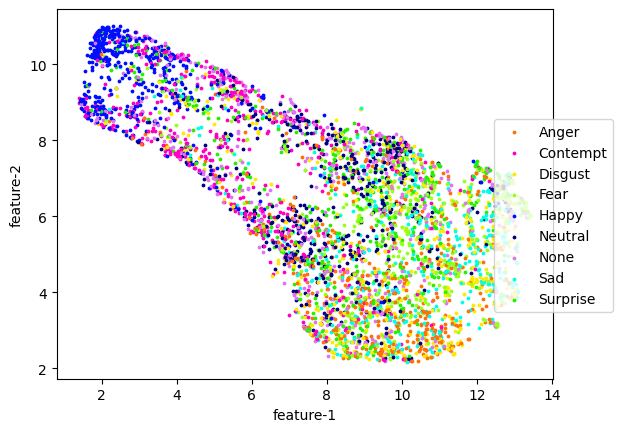

In [34]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 10, id2label)

100%|██████████| 4500/4500 [01:21<00:00, 55.37it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_3986753/3847203088.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


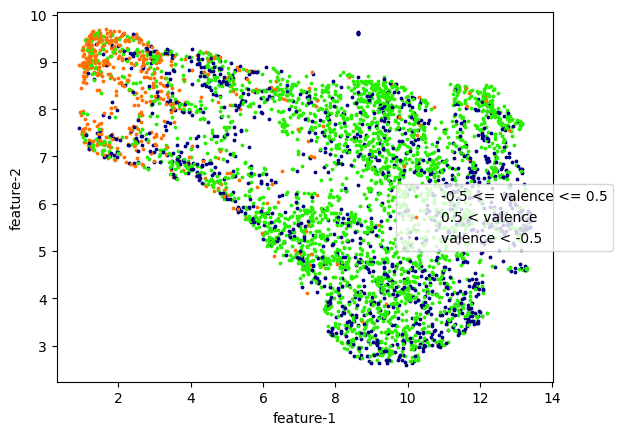

In [35]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            # val_label_dataset,
                            val_contrastive_dataset,
                            device)
plot_tokens(tokens, labels, 10, labeled_valence)

In [21]:
wandb.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,60141
